# Problem Set 1
## Members
    - Edmundo Arias – 202110688
    - Lucia Maldonado – 202012558
    - Juan Diego Heredia – 201813809

### Date: September 15th, 2024

# 0. Set Up

In [3]:
if (!require(pacman)) install.packages(pacman)
require(pacman)

Cargando paquete requerido: pacman



In [4]:
p_load(
  rio,         # Importar/exportar datos
  tidyverse,   # Manejo de datos ordenados (incluye dplyr, ggplot2, tidyr, readr, etc.)
  skimr,       # Resúmenes rápidos de datos
  gridExtra,   # Visualización de datos faltantes y organizar gráficos en cuadrículas
  corrplot,    # Gráficos de correlación
  stargazer,   # Tablas y salida para LaTeX
  MASS,        # Cálculos posteriores a la regresión y distribuciones estadísticas
  rvest,       # Web scraping
  httr,        # Realizar solicitudes HTTP (APIs y scraping)
  boot,        # Herramientas para Bootstrap y remuestreo estadístico
  broom,       # Convertir resultados de modelos a data frames ordenados
  lmtest,      # Pruebas estadísticas para modelos lineales
  fixest,      # Estimadores con efectos fijos (modelos lineales avanzados)
  sandwich,    # Estimaciones de varianza robusta
  future,      # Paralelización y ejecución asincrónica
  future.apply,# Versión paralela de funciones de `apply`
  furrr,       # Versión paralela de funciones de purrr
  memoise,     # Funciones con caché para evitar cálculos repetitivos
  parallel,    # Soporte para programación paralela
  foreach,     # Estructura para bucles paralelos
  doParallel,  # Backend para ejecutar `foreach` en paralelo
  caret        # Herramientas para la creación de modelos predictivos
)

In [ ]:
seed <- 555

The final dataset was exported to avoid rerunning the entire process each time. *For replication purposes, this step can be ignored.*

# 1. Datos

## 1.0. Web Scrapping

In [ ]:
plan(multisession) # Paralellizing

urls    <- paste0('https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_',1:10,'.html') # nolint
c_geih  <- future_lapply(
        urls,# nolint
        function(url){# nolint  
                html <- read_html(url)# nolint  
                return((html_node(html, "table") %>% html_table()))# nolint  
                })# nolint  

geih <- do.call(rbind, c_geih)
colnames(geih)[colnames(geih) == "" | is.na(colnames(geih))] <- "index"

## 1.1 Descripción de los datos

In [5]:
# Import the dataset (alternatively, you can run this code from scratch)
geih <- import("https://github.com/EAriasDeAbreu/BigDataML-Group2024/raw/main/Problem_Set_1/data/GEIH.RData")

Warning message:
"The `trust` argument of `import()` should be explicit for serialization formats
as of rio 1.0.3.
i Missing `trust` will be set to FALSE by default for RData in 2.0.0.
i The deprecated feature was likely used in the rio package.
  Please report the issue at <https://github.com/gesistsa/rio/issues>."


## 1.1. Numerical Vars

In [6]:
geih  <- geih %>%
            filter(                             # nolint
            age > 18 &                          # nolint
            ocu == 1 &                          # nolint
            !is.na(y_ingLab_m_ha) &                # nolint
            !is.na(age)) %>%
            mutate(log_wage = log(y_ingLab_m_ha + 1))  # nolint

In [7]:
# Crear variable dicotómica para p6580 (bonificaciones recibidas el mes pasado)
geih$bonif <- ifelse(geih$p6580 == 1, 1, ifelse(geih$p6580 == 2, 0, NA))

# Crear variable dicotómica para y_horasExtras_m (ingreso por horas extras)
geih$extra_h <- ifelse(geih$y_horasExtras_m > 0, 1, 0)

# Crear variable dicotómica para p7472 (ingresos por trabajo en desocupados)
geih$desoc <- ifelse(geih$p7472 == 1, 1, 0)

#Currently sex = 1 if Male, we need to invert this variable
geih$sex <- ifelse(geih$sex == 0, 1, 0)

# Cambiar los ingresos a millones
geih$ingtotob <- geih$ingtotob / 1000000

## Limpieza de la educación
geih <- geih %>% filter(!(p6210s1 %in% c(99, 98)))

In [8]:
# Load necessary libraries
library(dplyr)

# Create an empty matrix (3 rows, 11 columns) for the results
table1 <- matrix(NA, nrow = 5, ncol = 10)

males <- geih %>%
  filter(sex == 0)

females <- geih %>%
  filter(sex == 1)

##AGE - Males

summary_stats_1 <- males %>%
  summarise(N = n(),
            mean = mean(age, na.rm = TRUE),
            sd = sd(age, na.rm = TRUE),
            p50 = median(age, na.rm = TRUE))

# Store the summary statistics in the table
table1[1, 1] <- summary_stats_1$N
table1[1, 2] <- summary_stats_1$mean
table1[1, 3] <- summary_stats_1$sd
table1[1, 4] <- summary_stats_1$p50

##AGE - Females

summary_stats_2 <- females %>%
  summarise(N = n(),
            mean = mean(age, na.rm = TRUE),
            sd = sd(age, na.rm = TRUE),
            p50 = median(age, na.rm = TRUE))

# Store the summary statistics in the table
table1[1, 6] <- summary_stats_2$N
table1[1, 7] <- summary_stats_2$mean
table1[1, 8] <- summary_stats_2$sd
table1[1, 9] <- summary_stats_2$p50

# Perform t-test for gender
t_test_1 <- t.test(age ~ sex, data = geih)

# Store the p-value in the table
table1[1, 10] <- t_test_1$p.value


## Hourly Wage - Males

summary_stats_1 <- males %>%
  summarise(N = n(),
            mean = mean(y_ingLab_m_ha, na.rm = TRUE),
            sd = sd(y_ingLab_m_ha, na.rm = TRUE),
            p50 = median(y_ingLab_m_ha, na.rm = TRUE))

# Store the summary statistics in the table
table1[2, 1] <- summary_stats_1$N
table1[2, 2] <- summary_stats_1$mean
table1[2, 3] <- summary_stats_1$sd
table1[2, 4] <- summary_stats_1$p50

## Hourly Wage - Females

summary_stats_2 <- females %>%
  summarise(N = n(),
            mean = mean(y_ingLab_m_ha, na.rm = TRUE),
            sd = sd(y_ingLab_m_ha, na.rm = TRUE),
            p50 = median(y_ingLab_m_ha, na.rm = TRUE))

# Store the summary statistics in the table
table1[2, 6] <- summary_stats_2$N
table1[2, 7] <- summary_stats_2$mean
table1[2, 8] <- summary_stats_2$sd
table1[2, 9] <- summary_stats_2$p50

# Perform t-test for gender
t_test_1 <- t.test(y_ingLab_m_ha ~ sex, data = geih)

# Store the p-value in the table
table1[2, 10] <- t_test_1$p.value


## hoursWorkUsual - Males

summary_stats_1 <- males %>%
  summarise(N = n(),
            mean = mean(hoursWorkUsual, na.rm = TRUE),
            sd = sd(hoursWorkUsual, na.rm = TRUE),
            p50 = median(hoursWorkUsual, na.rm = TRUE))

# Store the summary statistics in the table
table1[3, 1] <- summary_stats_1$N
table1[3, 2] <- summary_stats_1$mean
table1[3, 3] <- summary_stats_1$sd
table1[3, 4] <- summary_stats_1$p50

## hoursWorkUsual - Females

summary_stats_2 <- females %>%
  summarise(N = n(),
            mean = mean(hoursWorkUsual, na.rm = TRUE),
            sd = sd(hoursWorkUsual, na.rm = TRUE),
            p50 = median(hoursWorkUsual, na.rm = TRUE))

# Store the summary statistics in the table
table1[3, 6] <- summary_stats_2$N
table1[3, 7] <- summary_stats_2$mean
table1[3, 8] <- summary_stats_2$sd
table1[3, 9] <- summary_stats_2$p50

# Perform t-test for gender
t_test_1 <- t.test(hoursWorkUsual ~ sex, data = geih)

# Store the p-value in the table
table1[3, 10] <- t_test_1$p.value


## ingtotob - Males

summary_stats_1 <- males %>%
  summarise(N = n(),
            mean = mean(ingtotob, na.rm = TRUE),
            sd = sd(ingtotob, na.rm = TRUE),
            p50 = median(ingtotob, na.rm = TRUE))

# Store the summary statistics in the table
table1[4, 1] <- summary_stats_1$N
table1[4, 2] <- summary_stats_1$mean
table1[4, 3] <- summary_stats_1$sd
table1[4, 4] <- summary_stats_1$p50

## ingtotob - Females

summary_stats_2 <- females %>%
  summarise(N = n(),
            mean = mean(ingtotob, na.rm = TRUE),
            sd = sd(ingtotob, na.rm = TRUE),
            p50 = median(ingtotob, na.rm = TRUE))

# Store the summary statistics in the table
table1[4, 6] <- summary_stats_2$N
table1[4, 7] <- summary_stats_2$mean
table1[4, 8] <- summary_stats_2$sd
table1[4, 9] <- summary_stats_2$p50

# Perform t-test for gender
t_test_1 <- t.test(ingtotob ~ sex, data = geih)

# Store the p-value in the table
table1[4, 10] <- t_test_1$p.value

## p6210s1 - Males

summary_stats_1 <- males %>%
  summarise(N = n(),
            mean = mean(p6210s1, na.rm = TRUE),
            sd = sd(p6210s1, na.rm = TRUE),
            p50 = median(p6210s1, na.rm = TRUE))

# Store the summary statistics in the table
table1[5, 1] <- summary_stats_1$N
table1[5, 2] <- summary_stats_1$mean
table1[5, 3] <- summary_stats_1$sd
table1[5, 4] <- summary_stats_1$p50

## p6210s1 - Females

summary_stats_2 <- females %>%
  summarise(N = n(),
            mean = mean(p6210s1, na.rm = TRUE),
            sd = sd(p6210s1, na.rm = TRUE),
            p50 = median(p6210s1, na.rm = TRUE))

# Store the summary statistics in the table
table1[5, 6] <- summary_stats_2$N
table1[5, 7] <- summary_stats_2$mean
table1[5, 8] <- summary_stats_2$sd
table1[5, 9] <- summary_stats_2$p50

# Perform t-test for gender
t_test_1 <- t.test(ingtotob ~ sex, data = geih)

# Store the p-value in the table
table1[5, 10] <- t_test_1$p.value


#Rownames
rownames(table1) <- c('Edad', 'Salario por Hora ($COP)', 'Horas trabajadas por Semana',
                      'Ingreso Total Observado (Millones $COP)', 'Años de Educación')

colnames(table1) <- c("Número", "Media", "Est. Des.", "P50", "",
                      "Número", "Media", "Est. Des.", "P50", "P-valor")


table1_formatted <- table1
table1_formatted[, 1] <- format(table1[, 1], nsmall = 0)
table1_formatted[, 6] <- format(table1[, 6], nsmall = 0)

# View the table
table1


,N<U+00FA>mero,Media,Est. Des.,P50,,N<U+00FA>mero,Media,Est. Des.,P50,P-valor
Edad,4909,36.133836,12.048049,34.000000,NA,4875,36.745026,11.818419,35.000000,1.132406e-02
Salario por Hora ($COP),4909,9043.918820,13398.114987,5266.204102,NA,4875,8692.289425,12413.994714,4882.998047,1.781198e-01
Horas trabajadas por Semana,4909,50.271135,12.153679,48.000000,NA,4875,45.876513,11.559108,48.000000,8.604296e-74
Ingreso Total Observado (Millones $COP),4909,1.948116,2.667885,1.189878,NA,4875,1.774154,2.302917,1.065557,5.562858e-04
A<U+00F1>os de Educaci<U+00F3>n,4909,7.075575,3.509765,7.000000,NA,4875,6.647795,3.527262,6.000000,5.562858e-04


El cuadro presenta estadísticas descriptivas a nivel de individuo para todas las variables continuas de interés en la base, condicional en género.



*   Se observa que la base de datos cuenta con 4910 hombres y 4875 mujeres, para un total de 9785 individuos.

*   La edad promedio es 36.43 años con un promedio ligeramente mayor en las mujeres  (0.62 años) respecto a los hombres.

*  El salario por hora promedio (incluyendo propinas y comisiones) en la muestra es de \$8868.71 pesos. Este salario es casi el doble del salario mínimo por hora en colombia para el año 2018 que se encontraba en 3,255 pesos.
*   El ingreso mensual mediano (P50) es cercano al salario mínimo y existe una alta desviación en los datos (la desviación en el ingreso total es de aproximadamente 2.45 millones de pesos).


In [ ]:
#Export it
latex_table <- xtable(table1, caption = "Resumen de Estadísticas")

file_path <- "/content/Punto_2_1.tex"
sink(file_path)
print(latex_table, type = "latex", include.rownames = TRUE, include.colnames = TRUE,
      digits = c(0, rep(2, 5), 0, rep(2, 4)))  # Set 0 decimals for columns 1 and 6
sink()

% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Sat Sep 14 22:55:16 2024
\begin{table}[ht]
\centering
\begin{tabular}{rrrrrrrrrrr}
  \hline
 & Número & Media & Est. Des. & P50 & V5 & Número & Media & Est. Des. & P50 & P-valor \\ 
  \hline
Edad & 4910.00 & 36.13 & 12.05 & 34.00 &  & 4875.00 & 36.75 & 11.82 & 35.00 & 0.01 \\ 
  Salario por Hora (\$COP) & 4910.00 & 9042.88 & 13396.95 & 5266.20 &  & 4875.00 & 8692.29 & 12413.99 & 4883.00 & 0.18 \\ 
  Horas trabajadas por Semana & 4910.00 & 50.27 & 12.15 & 48.00 &  & 4875.00 & 45.88 & 11.56 & 48.00 & 0.00 \\ 
  Ingreso Total Observado (Millones \$COP) & 4910.00 & 1.95 & 2.67 & 1.19 &  & 4875.00 & 1.77 & 2.30 & 1.07 & 0.00 \\ 
  Años de Educación & 4910.00 & 7.09 & 3.75 & 7.00 &  & 4875.00 & 6.65 & 3.53 & 6.00 & 0.00 \\ 
   \hline
\end{tabular}
\caption{Resumen de Estadísticas} 
\end{table}


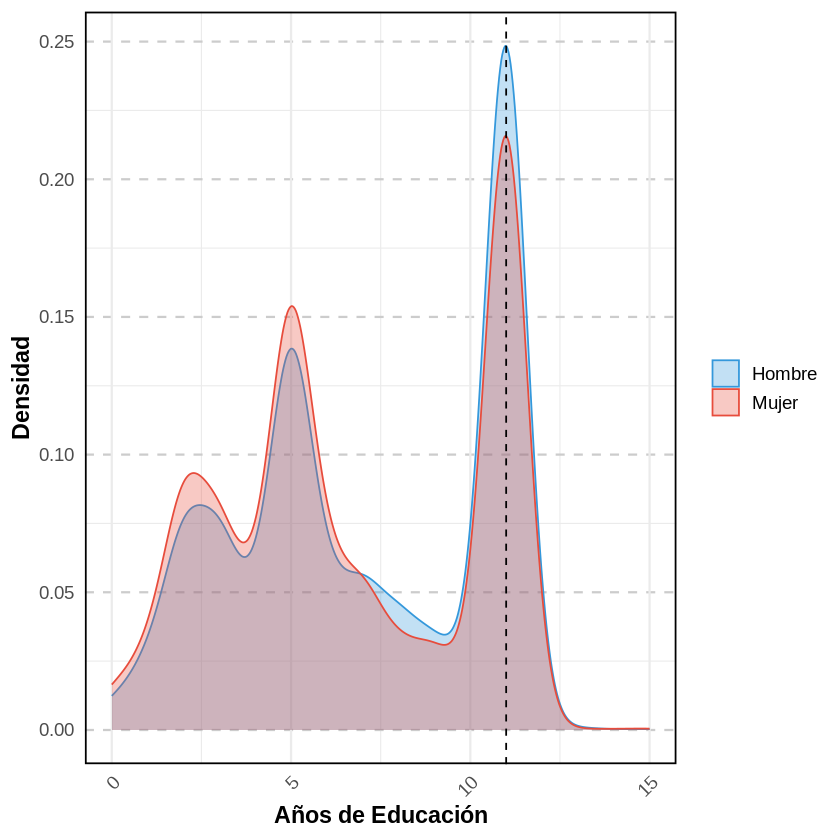

In [ ]:
##Hist Schooling
combined_data <- bind_rows(
  males %>% mutate(gender = "Hombre", p6210s1 = as.numeric(p6210s1)),
  females %>% mutate(gender = "Mujer", p6210s1 = as.numeric(p6210s1))
)

# Crear el gráfico de densidad kernel con línea vertical en x = 11
plot_sch <- ggplot(combined_data, aes(x = p6210s1, color = gender, fill = gender)) +
  geom_density(alpha = 0.3) +
  geom_vline(xintercept = 11, linetype = "dashed", color = "black") +
  labs(x = "Años de Educación", y = "Densidad") +
  scale_color_manual(values = c("Hombre" = "#3498db", "Mujer" = "#e74c3c")) +
  scale_fill_manual(values = c("Hombre" = "#3498db", "Mujer" = "#e74c3c")) +
  theme_minimal(base_size = 14) +
  theme(legend.title = element_blank(),
  panel.border = element_rect(color = "black", fill = NA, size = 1),
  axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_text(face = "bold", size = 14),
        plot.title = element_text(face = "bold", size = 16),
        panel.grid.major.y = element_line(color = "grey80", linetype = "dashed"))

plot_sch

In [ ]:
ggsave("/content/Punto_2_6.pdf", plot = plot_sch, width = 10, height = 7, units = "in")

## 1.2 Categorical Vars

### 1.2.1 Oficio

In [ ]:
# Load necessary libraries
library(dplyr)
library(knitr)

category_descriptions <- tibble(
  oficio = c(39, 45, 58, 54, 53, 33, 21, 55, 13, 3),
  description = c("Personal Administrativo",
                   "Vendedores",
                   "Seguridad pública",
                   "Empleados domésticos",
                   "Servicios de Alimento",
                   "Cajeros",
                   "Personal Directivo",
                   "Seguridad Privada",
                   "Docentes",
                   "Técnicos Especializados")
)

oficio_summary <- geih %>%
  count(oficio) %>%  # Count occurrences of each category
  mutate(share = n / sum(n) * 100) %>%  # Calculate share as percentage
  arrange(desc(share)) %>%  # Arrange in descending order by share
  slice_head(n = 10) %>%  # Select the top 10 categories with the highest share
  left_join(category_descriptions, by = "oficio") %>%  # Join with descriptions
  select(description, oficio, n, share)  # Reorder columns to place description first

# Print the summary table
kable(oficio_summary, col.names = c("Nombre", "Código DANE", "Número", "Porcentaje (%)"),
      caption = "Top 10 Categorías de Oficio por Porcentaje")




Table: Top 10 Categorías de Oficio por Porcentaje

|Nombre                  | Código DANE| Número| Porcentaje (%)|
|:-----------------------|-----------:|------:|--------------:|
|Personal Administrativo |          39|    805|       8.227719|
|Vendedores              |          45|    769|       7.859771|
|Seguridad pública       |          58|    607|       6.204007|
|Empleados domésticos    |          54|    566|       5.784955|
|Servicios de Alimento   |          53|    549|       5.611202|
|Cajeros                 |          33|    424|       4.333606|
|Personal Directivo      |          21|    419|       4.282502|
|Seguridad Privada       |          55|    409|       4.180294|
|Docentes                |          13|    375|       3.832788|
|Técnicos Especializados |           3|    365|       3.730580|

In [ ]:
#Export it
# Generate LaTeX table
kable(oficio_summary, col.names = c("Nombre", "Código DANE", "Número", "Porcentaje (%)"),
      caption = "Top 10 Categorías de Oficio por Porcentaje",
      format = "latex") %>%
  cat(file = "Punto_2_2.tex")


En términos de variables categóricas de interés, el cuadro \ref{table_2_2} presenta los 10 tipos de oficio más comunes entre los individuos en la muestra.



*   La mayoría (8.23\% de la muestra) tienen cargos administrativos como almacenistas, bodegueros, auxiliares administrativos, recepcionistas, y empleados en oficinas de viajes, bibliotecas, y seguros.

*   El oficio con una mayor participación femenina son los servicios domésticos con un 98,4\% de sus empleados siendo mujeres
*   El oficio con mayor composición de hombres son los servicios de seguridad pública (polícia, bomberos, etc) con un 85,17\% de hombres en su fuerza laboral.


### 1.2.2. Size Firm

In [ ]:

size_firm_descriptions <- tibble(
  sizeFirm = c(1, 2, 3, 4, 5),
  description = c("Cuenta Propia",
                   "2 - 5 Trabajadores",
                   "6 - 10 Trabajadores",
                   "11 - 50 Trabajadores",
                   ">50 Trabajadores")
)


size_firm_summary <- geih %>%
  count(sizeFirm) %>%
  mutate(share = n / sum(n) * 100) %>%
  arrange(desc(share)) %>%
  left_join(size_firm_descriptions, by = "sizeFirm") %>%
  select(description, sizeFirm, n, share)

# Print
kable(size_firm_summary, col.names = c("Nombre", "Código DANE", "Número", "Porcentaje (%)"),
      caption = "Tamaño de Empresa")




Table: Tamaño de Empresa

|Nombre               | Código DANE| Número| Porcentaje (%)|
|:--------------------|-----------:|------:|--------------:|
|>50 Trabajadores     |           5|   5072|      51.834440|
|11 - 50 Trabajadores |           4|   1676|      17.128258|
|2 - 5 Trabajadores   |           2|   1665|      17.015841|
|6 - 10 Trabajadores  |           3|    834|       8.523250|
|Cuenta Propia        |           1|    538|       5.498212|

In [ ]:
#Export it
# Generate LaTeX table
kable(size_firm_summary, col.names = c("Nombre", "Código DANE", "Número", "Porcentaje (%)"),
      caption = "Tamaño de Empresa",
      format = "latex") %>%
  cat(file = "/content/Punto_2_3.tex")

### 1.2.3. Employment Relationship

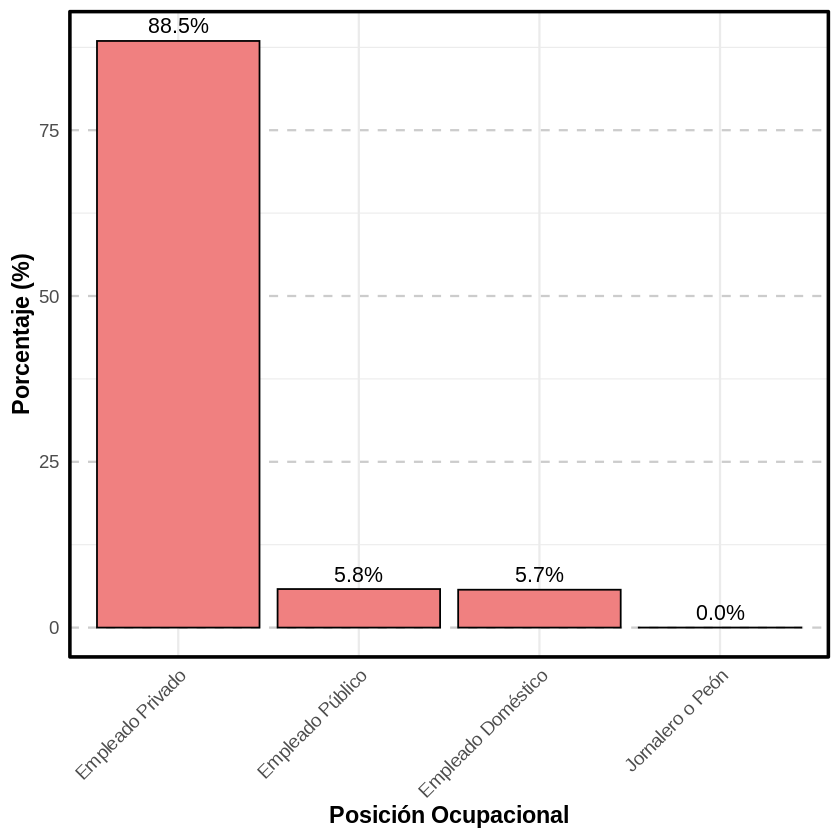

In [ ]:
relab_summary <- geih %>%
  count(relab) %>%
  mutate(share = n / sum(n) * 100) %>%
  arrange(desc(share))

plot2 <- ggplot(relab_summary, aes(x = reorder(as.factor(relab), -share), y = share)) +
  geom_bar(stat = "identity", fill = "lightcoral", color = "black") +
  geom_text(aes(label = sprintf("%.1f%%", share)),
            vjust = -0.5, color = "black", size = 4.5) +
  scale_x_discrete(labels = c("1" = "Empleado Privado",
                              "2" = "Empleado Público",
                              "3" = "Empleado Doméstico",
                              "8" = "Jornalero o Peón")) +
  labs(x = "Posición Ocupacional", y = "Porcentaje (%)") +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_text(face = "bold", size = 14),
        plot.title = element_text(face = "bold", size = 16),
        panel.grid.major.y = element_line(color = "grey80", linetype = "dashed"),
        panel.border = element_rect(color = "black", fill = NA, size = 1)) +
  coord_cartesian(clip = 'off')
plot2

In [ ]:
ggsave("/content/pdf", plot = plot2, width = 10, height = 7, units = "in")

Las personas en nuestra muestra tienen relaciones laborales (variable $relab$) con entes privados, públicos, contratistas domésticos o temporales a través de jornales .

### 1.2.4. Pension

In [ ]:
freq_table <- table(geih$cotPension)

# Create a data frame with frequencies and percentages
result <- data.frame(
  Category = names(freq_table),
  Frequency = as.vector(freq_table),
  Percentage = round(100 * prop.table(freq_table), 2)
)

# Print the table
print(result)

  Category Frequency Percentage.Var1 Percentage.Freq
1        1      7484               1           76.48
2        2      2194               2           22.42
3        3       107               3            1.09


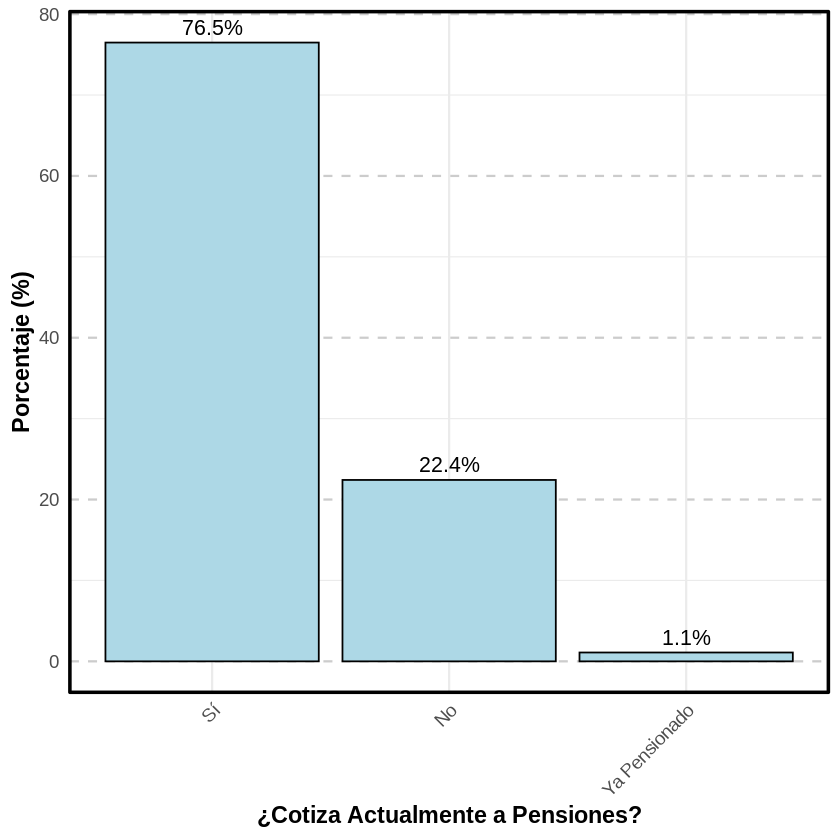

In [ ]:
relab_summary <- geih %>%
  count(cotPension) %>%
  mutate(share = n / sum(n) * 100) %>%
  arrange(desc(share))

plot3 <- ggplot(relab_summary, aes(x = reorder(as.factor(cotPension), -share), y = share)) +
  geom_bar(stat = "identity", fill = "lightblue", color = "black") +
  geom_text(aes(label = sprintf("%.1f%%", share)),
            vjust = -0.5, color = "black", size = 4.5) +
  scale_x_discrete(labels = c("1" = "Sí",
                              "2" = "No",
                              "3" = "Ya Pensionado")) +
  labs(x = "¿Cotiza Actualmente a Pensiones?", y = "Porcentaje (%)") +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_text(face = "bold", size = 14),
        plot.title = element_text(face = "bold", size = 16),
        panel.grid.major.y = element_line(color = "grey80", linetype = "dashed"),
        panel.border = element_rect(color = "black", fill = NA, size = 1)) +
  coord_cartesian(clip = 'off')
plot3

In [ ]:
ggsave("/content/Punto_2_5.pdf", plot = plot3, width = 10, height = 7, units = "in")

ERROR: Error in ggsave("/content/Punto_2_5.pdf", plot = plot3, width = 10, height = 7, : could not find function "ggsave"


La mayoría de los individuos cotiza a pensiones (76.5\%), mientras que un 1.1\% de ellos trabaja (dado que la muestra está compuesta solo por individuos empleados) estando pensionado.

# 2. Age-Wage Profile

In [ ]:
age_wage_profile <- lm(log_wage ~ age + I(age^2), data = geih)

In [ ]:
fit_model <- function(data, indices) {
    fit <- lm(log_wage ~ age + I(age^2), data = data[indices, ])
    coef(fit)
}

In [ ]:
set.seed(seed)
boot_results <- boot(data = geih, statistic = fit_model, R = 1000)
boot_se <- apply(boot_results$t, 2, sd)


peak_age <- -coef(age_wage_profile)[2] / (2 * coef(age_wage_profile)[3])
peak_age_ci <- quantile(boot_results$t[, 2], c(0.025, 0.975))

peak_age <- -coef(age_wage_profile)[2] / (2 * coef(age_wage_profile)[3])
peak_age_ci <- c(
    peak_age-quantile(boot_results$t[, 2],0.025),
    peak_age+quantile(boot_results$t[, 2],0.975))

age_range <- seq(min(geih$age), max(geih$age), length.out = 100)
predicted_values <- predict(age_wage_profile, newdata = data.frame(age = age_range), interval = "confidence")

In [ ]:
stargazer(age_wage_profile,
    se = list(boot_se), 
    type = "text",
    title = "Age-Wage Profile Regression Results",
    column.labels = c("Coefficients", "Bootstrap SE"),
    omit.stat = c("rsq", "adj.rsq", "f", "ser"),  
)
cat("\nPeak Age Analysis:\n")
cat("Estimated Peak Age:", round(peak_age, 2), "\n")
cat("95% CI for Peak Age:", round(peak_age_ci[1], 2), "to", round(peak_age_ci[2], 2), "\n\n")


Age-Wage Profile Regression Results
                        Dependent variable:    
                    ---------------------------
                               ln_w            
                           Coefficients        
-----------------------------------------------
age                          0.065***          
                              (0.004)          
                                               
I(age2)                      -0.001***         
                             (0.0001)          
                                               
Constant                     7.426***          
                              (0.077)          
                                               
-----------------------------------------------
Observations                   9,785           
R2                             0.039           
Adjusted R2                    0.039           
Residual Std. Error      0.712 (df = 9782)     
F Statistic          197.349*** (df = 2; 9782) 
Not

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


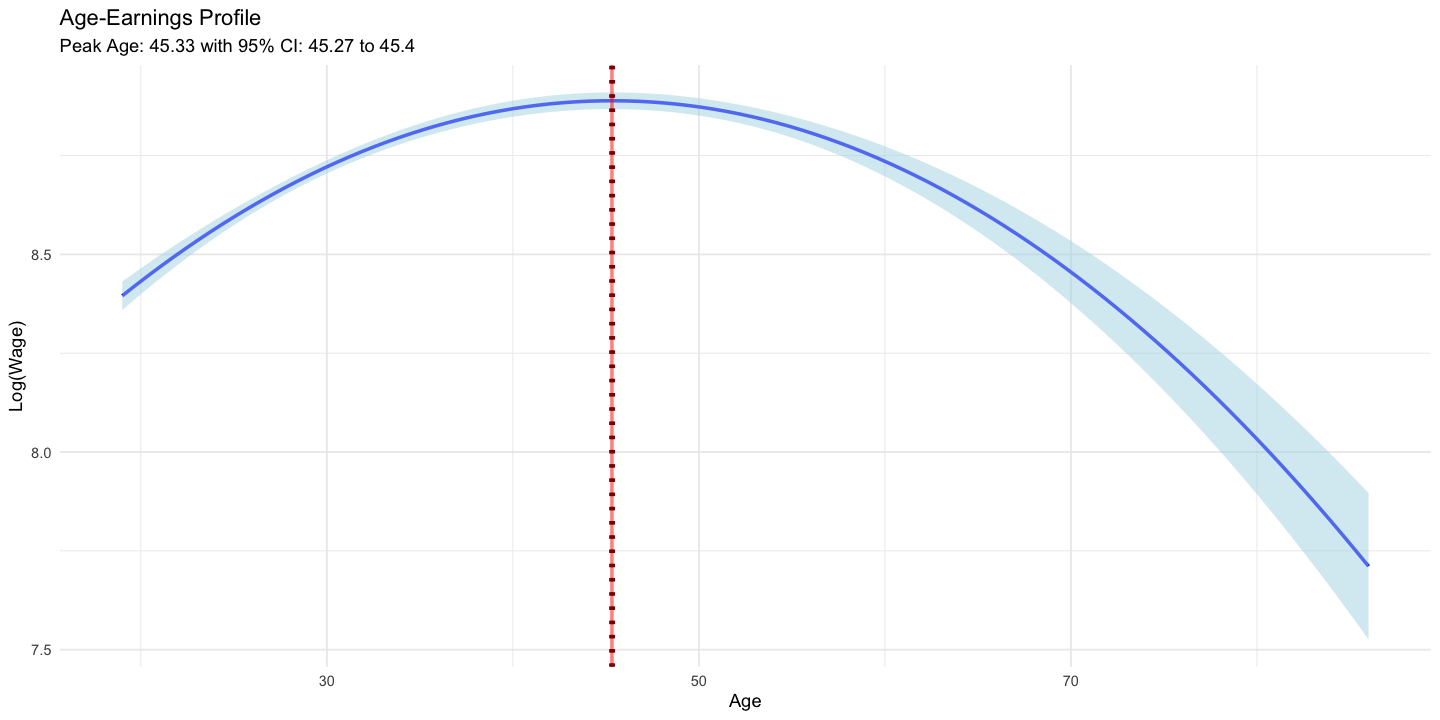

In [ ]:
df_plot <- data.frame(
  age = age_range,
  predicted_log_wage = predicted_values[, "fit"],
  lwr = predicted_values[, "lwr"],
  upr = predicted_values[, "upr"]
)


options(repr.plot.width = 12, repr.plot.height = 6)

ggplot(geih_plot, aes(x = edad, y = salario_logaritmico_estimado)) +
  geom_line(color = "blue", size = 1) +  # Curva de predicción
  geom_ribbon(aes(ymin = inferior, ymax = superior), fill = "lightblue", alpha = 0.5) +  # Intervalo de confianza
  geom_vline(xintercept = peak_age, color = "red", size = 1, alpha = 0.5) +  # Línea de la edad pico
  geom_vline(xintercept = peak_age_ci[1], linetype = "dotted", color = "darkred", size = 1) +  # CI inferior
  geom_vline(xintercept = peak_age_ci[2], linetype = "dotted", color = "darkred", size = 1) +  # CI superior
  labs(
    title = "Salario por Edad",
    subtitle = paste("Edad Pico:", round(peak_age, 2), "con IC del 95%:", round(peak_age_ci[1], 2), "a", round(peak_age_ci[2], 2)),
    x = "Edad",
    y = "Log(Salario)"
  ) +
  theme_minimal()

In [ ]:
#TODO: interpretacion

# 3. Gender Earnings GAP

Las implicaciones de los sesgos de género dentro de la remuneración en el mercado laboral han sido una preocupación latente tanto para los investigadores como para los hacedores de política en el último medio siglo. Algunas investigaciones han encontrado un rezago en la participación femenina como porcentaje del total de empleados en el país (véase Palomino et al., 2015), y estudios recientes han determinado que, de continuar al ritmo actual, **se necesitarán 131 años para cerrar las brechas económicas de género** (World Economic Forum, 2023). Colombia, por su parte, tiene una brecha de género de 24,9% en términos del Global Gap Index, que pondera la paridad en acceso a participación económica, logro educativo, salud y participación política, y ocupa el lugar 42 entre los 146 países considerados en esta medición, donde Islandia es el país en el primer puesto (World Economic Forum, 2023). En esta sección, analizaremos los **diferenciales salariales de género** en Bogotá a través de los datos del Reporte de Medición de Pobreza Monetaria y Desigualdad, 2018.

## 3.0. Importar los Datos

In [ ]:
# Wage per hour
summary(geih$y_ingLab_m_ha)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   326.7   4226.5   5071.8   8868.2   8101.9 350583.3 

## 3.1. Brecha Incondicional

Una primera aproximación a la disparidad en los retornos laborales basado en el género consiste en una **simple diferencia de promedio** en el salario devengado por cada género. En este trabajo consideramos el enfoque tradicional de género binario basado en el sexo al nacer. En particular, estamos interesados en la regresión:


\begin{equation}
Log(w_i) = \beta_1 + \beta_2 Female + u_i
\end{equation}

donde $Female_i$ es una variable dicótoma con el valor de 1 cuando el individuo $i$ es una mujer, y $w_i$ es el salario por hora de un individuo ($i$).


In [ ]:
#Run the model
model_gap <- lm(log_wage ~ sex, data = geih)
robust_se <- vcovHC(model_gap, type = "HC1") # heteroskedasticity robust SE
robust_summary <- coeftest(model_gap, vcov = robust_se)
print(robust_summary)


t test of coefficients:

             Estimate Std. Error  t value  Pr(>|t|)    
(Intercept)  8.754597   0.010123 864.8138 < 2.2e-16 ***
sex         -0.047558   0.014681  -3.2394  0.001202 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [ ]:
#Export it (You need to have an Drive account Liked to save this)
stargazer(model_gap, type = "latex",
          covariate.labels = c("$Female$", "$\\beta_0$"),
          out = "/content/Punto_4_1.tex")



% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: Sun, Sep 15, 2024 - 12:10:35 AM
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{1}{c}{\textit{Dependent variable:}} \\ 
\cline{2-2} 
\\[-1.8ex] & log\_wage \\ 
\hline \\[-1.8ex] 
 $Female$ & $-$0.048$^{***}$ \\ 
  & (0.015) \\ 
  & \\ 
 $\beta_0$ & 8.755$^{***}$ \\ 
  & (0.010) \\ 
  & \\ 
\hline \\[-1.8ex] 
Observations & 9,784 \\ 
R$^{2}$ & 0.001 \\ 
Adjusted R$^{2}$ & 0.001 \\ 
Residual Std. Error & 0.726 (df = 9782) \\ 
F Statistic & 10.497$^{***}$ (df = 1; 9782) \\ 
\hline 
\hline \\[-1.8ex] 
\textit{Note:}  & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\ 
\end{tabular} 
\end{table} 


Los resultados indican que el salario por hora promedio para los hombres en la muestra es de 6,342 pesos por hora (i.e. $e^{\beta_0 = E[ln(wage_i) | sex = 0]}= e^{8.75} = \$6,342$ COP). \footnote{\footnotesize{Los individuos considerados en la regresión son solo aquellos con una edad mayor a 18 años y con un salario reportado (i.e. $non-missing$).}} Este salario es casi el doble del salario mínimo por hora en colombia para el año 2018 que se encontraba en 3,255 pesos. La regresión también indica que \textbf{las mujeres en la muestra en promedio ganaban 4.7\% menos por hora en 2018} (i.e. $\beta_1 * 100$), para un salario promedio por hora para las mujeres en la muestra de 6,051 pesos (i.e. $e^(8.755-0.047) = 6,051$), **290.87 pesos menos que los hombres**. Note que esta diferencia es estadísticamente distinta de cero para niveles de significancia (i.e. de rechazar la hipótesis nula cuando en realidad no hay efecto) de hasta el 1\%.

## 3.2. Brecha Condicional

La existencia de factores adicionales a sesgos de género en quienes determinan los salarios hacen necesario la inclusión en el modeloinial de características adicionales en las mujeres que permitan una mejor predicción del salario por hora. Esta sección calcula el salario por hora promedio para individuos encuestados en la GEIH (2018) en Bogotá condicional en características del empleo y el trabajador. En particular estima la ecuación:

\begin{equation}
    \small{
    Log(w_{ij}) = \alpha_1 + \alpha_2 Female_i + \alpha_3 Age_i + \alpha_4 Age_i^2 + \alpha_5 Schooling\_Years_i + \alpha_6 Size\_firm_{j} + \alpha_7 Pension_i + \epsilon_{ij}}
\end{equation}

###3.2.1.a. What controls to use?

####3.2.1.a.1. Eyeballing

In [ ]:
library(lfe)
# define control variables
geih$age_squared <- geih$age^2
geih$sizeFirm <- as.character(geih$sizeFirm)
geih$cotPension <- as.character(geih$cotPension)


controls <- c("age", "p6210s1", "hoursWorkUsual", "sizeFirm", "cotPension", "age_squared")

## --> "p6220s1" refers to education attainment

# i) FWL: Standard SE's
formula_controls <- as.formula(paste(
    "log_wage ~",
    paste(controls, collapse = " + "), "| depto + relab + oficio"
))
formula_controls_sex <- as.formula(paste(
    "sex ~",
    paste(controls, collapse = " + "), "| depto + depto + relab + oficio"
))

# partial out  controls
residuals_y <- feols(formula_controls, data = geih)$residuals
residuals_sex <- feols(formula_controls_sex, data = geih)$residuals

# regress residuals
fwl_model <- lm(residuals_y ~ residuals_sex)

robust_se_fwl <- vcovHC(fwl_model, type = "HC1") # heteroskedasticity robust SE
robust_summary_fwl <- coeftest(fwl_model, vcov = robust_se)

# stats
fwl_coef <- coef(fwl_model)[2]
fwl_se <- sqrt(vcov(fwl_model)[2, 2])

In [ ]:
#Let us ensure that we followed the procedure correctly by focusing on the coefficients for gender.


no_fwl_model <- felm(log_wage ~ sex + age  + p6210  + hoursWorkUsual + sizeFirm + cotPension + age_squared | oficio + relab, data = geih)
print(no_fwl_model)

           sex            age          p6210 hoursWorkUsual       sizeFirm 
    -0.1039389      0.0324755      0.1169793     -0.0104134      0.1053534 
    cotPension    age_squared 
    -0.1809787     -0.0002729 


3.2.1.a.1.1. Bootstrap



In [ ]:
# remember our old f?
boot_fwl <- function(data, indices) {
    resid_y <- residuals_y[indices]
    resid_sex <- residuals_sex[indices]
    boot_model <- lm(resid_y ~ resid_sex)
    return(coef(boot_model)[2])
}

# bootstrap
set.seed(555)
boot_results <- boot(data = geih, statistic = boot_fwl, R = 10000)

# bootstrap standard error

boot_se <- sd(boot_results$t)

In [ ]:
print(boot_se)

[1] 0.01270855


3.2.1.a.1.2. Results

In [ ]:
##Export results:

sex_only_model <- fwl_coef
sex_only_se <- boot_se # calculated bootstrap

#coefficients
sex_model_custom <- list()
sex_model_custom$coefficients <- sex_only_model
sex_model_custom$se <- sex_only_se


custom_model <- lm(log_wage ~ 0 + sex, data = geih) # format
coef_custom <- coef(custom_model)
coef_custom["sex"] <- sex_only_model
se_custom <- rep(NA, length(coef_custom)) # empty errors for all, but sex
se_custom["sex"] <- sex_only_se
stargazer(model_gap, no_fwl_model, custom_model,
          coef = list(coef(model_gap), coef(no_fwl_model), coef_custom),
          se = list(summary(model_gap)$coefficients[, "Std. Error"], summary(no_fwl_model)$coefficients[, "Std. Error"], se_custom),
          type = "text",
          column.labels = c("Incondicional", "Condicional", "Condicional"),
          covariate.labels = c("Sexo", "Edad", "Oficio", "P6210", "Relación Laboral", "Horas Usuales"),
          omit.stat = c("f", "ser", "adj.rsq"),
          add.lines = list(
            c("Bootstrap", "No", "No", "Sí"),
            c("Covariables", "Sí", "Sí", "No")
          ),
          no.space = TRUE)


                          Dependent variable:         
                 -------------------------------------
                               log_wage               
                      OLS         felm         OLS    
                 Incondicional Condicional Condicional
                      (1)          (2)         (3)    
------------------------------------------------------
Sexo               -0.048***    -0.104***   -0.097*** 
                    (0.015)      (0.012)     (0.013)  
Edad                            0.032***              
                                 (0.003)              
Oficio                          0.117***              
                                 (0.007)              
P6210                           -0.010***             
                                (0.0004)              
Relación Laboral                0.105***              
                                 (0.005)              
Horas Usuales                   -0.181***             
         

In [ ]:
stargazer(model_gap, no_fwl_model, custom_model,
          coef = list(coef(model_gap), coef(no_fwl_model), coef_custom),
          se = list(summary(model_gap)$coefficients[, "Std. Error"], summary(no_fwl_model)$coefficients[, "Std. Error"], se_custom),
          type = "latex",
          column.labels = c("Incondicional", "Condicional", "Condicional"),
          covariate.labels = c("Sexo", "Edad", "Oficio", "P6210", "Relación Laboral", "Horas Usuales"),
          omit.stat = c("f", "ser", "adj.rsq"),
          add.lines = list(
            c("Bootstrap", "No", "No", "Sí"),
            c("Covariables", "Sí", "Sí", "No")
          ),
          no.space = TRUE,
          out = "/content/Punto_4_1.tex")


% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: Sun, Sep 15, 2024 - 12:12:22 AM
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{3}{c}{\textit{Dependent variable:}} \\ 
\cline{2-4} 
\\[-1.8ex] & \multicolumn{3}{c}{log\_wage} \\ 
\\[-1.8ex] & \textit{OLS} & \textit{felm} & \textit{OLS} \\ 
 & Incondicional & Condicional & Condicional \\ 
\\[-1.8ex] & (1) & (2) & (3)\\ 
\hline \\[-1.8ex] 
 Sexo & $-$0.048$^{***}$ & $-$0.104$^{***}$ & $-$0.097$^{***}$ \\ 
  & (0.015) & (0.012) & (0.013) \\ 
  Edad &  & 0.032$^{***}$ &  \\ 
  &  & (0.003) &  \\ 
  Oficio &  & 0.117$^{***}$ &  \\ 
  &  & (0.007) &  \\ 
  P6210 &  & $-$0.010$^{***}$ &  \\ 
  &  & (0.0004) &  \\ 
  Relación Laboral &  & 0.105$^{***}$ &  \\ 
  &  & (0.005) &  \\ 
  Horas Usuales &  & $-$0.181$^{***}$ &  \\ 
  &  & (0.014) &  \\ 
  age\_squar

Los resultados sugieren que, entre individuos con la misma edad, nivel de educación, estatus de afiliación a la seguridad social, y contratados por empresas en el mismo sector y bajo el mismo tipo de contrato (empleado, jornalero, etc.), **las mujeres ganan un 10,4\% menos por hora que los hombres**. Note que el porcentaje de la variación del logarítmo del ingreso por hora observado explicada por el modelo subió a más del 50\% al considerar estas nuevas covariables. Los resultados de esta nueva regresión indican que la omisión de características relevantes en la explicación del salario por hora en la especificación inicial estaban llevando a **subestimar el diferencial salarial de género**. Dado que la primera especificación es nada más que un promedio, variación entre los grupos podían ser capaces de reducir la diferencia promedio de salario entre hombres y mujeres.

### 3.3 Plot


#### 3.3.1 Prediction

In [ ]:
summary(geih$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  19.00   27.00   34.00   36.44   45.00   86.00 

In [ ]:
table(geih$oficio)


  1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21 
 12 197 365   2  17  55  51 123  41 169 103 375   4  31  62  14  20 129   1 419 
 30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  49  50  51  52 
104   9 107 424  44  10  37 132 203 805  38  24  48  13 161 769   2  30  23   5 
 53  54  55  56  57  58  59  61  62  63  70  72  73  74  75  76  77  78  79  80 
549 566 409  21  20 607 253   1  32   2  56   6   2  10  12   2 137   1 182  48 
 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 
 44   1  67  99  98   3  95   1  19  52  10  30  50  11 359   2 356 334  59 

In [ ]:
# Load necessary libraries
library(dplyr)
library(tidyr)
library(ggplot2)

# Create factor levels for fixed effects
geih_plot <- geih %>%
  mutate(oficio = as.factor(oficio),
         relab = as.factor(relab))

geih_plot$age_squared <- geih_plot$age^2

# Fit the model with fixed effects using lm
model <- lm(log_wage ~ sex + age + p6210 + hoursWorkUsual + sizeFirm + cotPension + age_squared +
             factor(oficio) + factor(relab), data = geih_plot)


age_seq <- seq(from = 19, to = 86, by = 1)
new_data <- data.frame(
  age = age_seq,
  age_squared = age_seq^2,
  sex = c(0,1), # Assuming the mean value for sex
  p6210 = mean(geih$p6210, na.rm = TRUE), # Assuming the mean value for p6210
  hoursWorkUsual = mean(geih$hoursWorkUsual, na.rm = TRUE), # Assuming the mean value for hoursWorkUsual
  sizeFirm = "1", # Assuming the mean value for sizeFirm
  cotPension = "1", # Assuming the mean value for cotPension
  oficio = 9,
  relab = 2
)

# Predict log_wage for the new data and get confidence intervals
predictions <- predict(model, newdata = new_data, interval = "confidence")

# Bind predictions to new_data
new_data <- bind_cols(new_data, as.data.frame(predictions))

#Peak Age
max_fit_sex_0 <- new_data$age[new_data$sex == 0][which.max(new_data$fit[new_data$sex == 0])]
max_fit_sex_1 <- new_data$age[new_data$sex == 1][which.max(new_data$fit[new_data$sex == 0])]


In [ ]:
print(max_fit_sex_0)

[1] 53


#### 3.3.2 Plot

En términos de la evolución salarial a través de los años, la figura generada en esta sección presenta el salario por hora en términos logarítmicos para todas las edades por encima de 18 años disponibles en la muestra. La figura calcula los salarios por hora logarítmicos predichos para individuos con valores promedio en las demás variables explicativas númericas ($Schooling\_Years\_i$, $Size\_firm\_j$, etc.). Las predicciones se concentran para empleos relacionados con `Economía' (i.e. $Oficio == 99$) y de característica formal en empresas particulares (i.e. $Relab == 1$). Los intervalos de confianza fueron calculados utilizando la variabilidad de los errores estándar de los coeficientes del modelo de regresión ajustado, asumiendo una distribución normal de los errores (método delta).

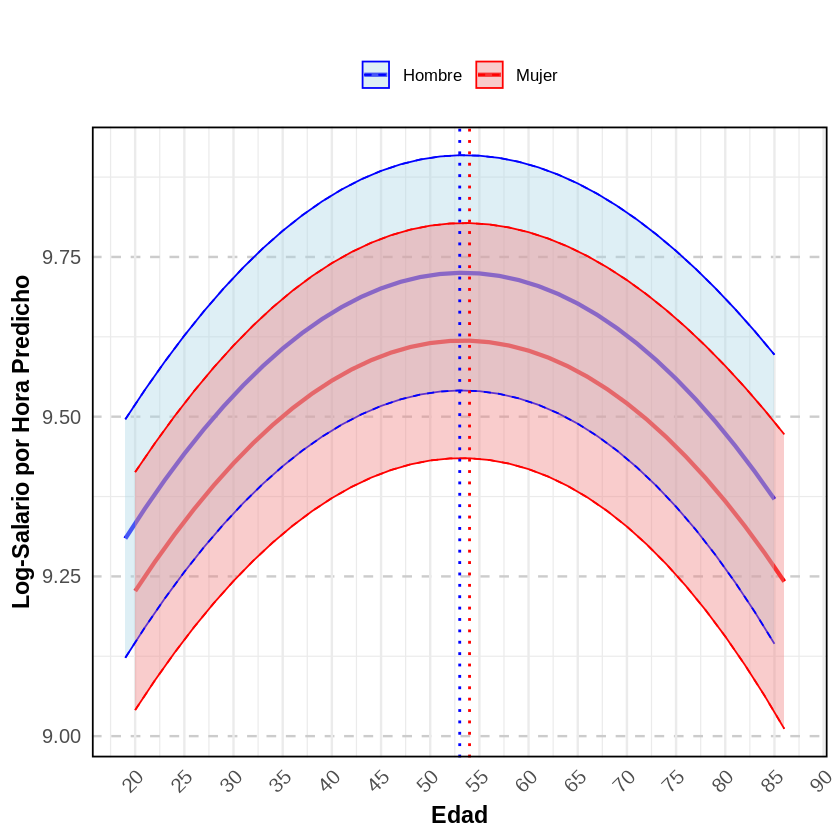

In [ ]:
plot <- ggplot(new_data, aes(x = age, y = fit, color = factor(sex))) +
  geom_line(size = 1.2) + # Thicker lines for better visibility
  geom_ribbon(aes(ymin = lwr, ymax = upr, fill = factor(sex)), alpha = 0.4) + # Increased alpha for clearer confidence intervals
  geom_line(aes(y = lwr, color = factor(sex)), linetype = "dashed") + # Dashed line for lower confidence interval
  geom_line(aes(y = upr, color = factor(sex)), linetype = "dashed") + # Dashed line for upper confidence interval
  geom_vline(xintercept = max_fit_sex_0, linetype = "dotted", color = "blue", size = 0.8) + # Vertical line for max fit when sex = 0
  geom_vline(xintercept = max_fit_sex_1, linetype = "dotted", color = "red", size = 0.8) + # Vertical line for max fit when sex = 1
  scale_x_continuous(breaks = seq(20, 100, by = 5), limits = c(19, 87)) + # Set breaks and limits for x-axis
  scale_color_manual(values = c("blue", "red"), labels = c("Hombre", "Mujer")) + # Custom colors and labels for sex
  scale_fill_manual(values = c("lightblue", "lightcoral"), labels = c("Hombre", "Mujer")) + # Lighter fill colors for better contrast
  labs(x = "Edad", y = "Log-Salario por Hora Predicho", color = "Sex", fill = "Sex") +
  theme_minimal(base_size = 15) + # Increase base font size for better readability
  theme(
    legend.position = "top", # Move legend to the top
    legend.title = element_text(size = 12), # Increase font size of legend title
    legend.text = element_text(size = 10), # Increase font size of legend text
    axis.title = element_text(size = 14), # Increase font size of axis titles
    axis.text = element_text(size = 12) # Increase font size of axis labels
  ) +
  ggtitle("") +
  theme(legend.title = element_blank(),
  panel.border = element_rect(color = "black", fill = NA, size = 1),
  axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_text(face = "bold", size = 14),
        plot.title = element_text(face = "bold", size = 16),
        panel.grid.major.y = element_line(color = "grey80", linetype = "dashed")) # Center and increase font size of plot title

plot

In [ ]:
ggsave("/content/Punto_4_2.pdf", plot = plot, width = 10, height = 7, units = "in")

**Takeaways**


*   (1) las mujeres tienen una tasa de retorno salarial a través de sus años de vida menor que la de los hombres, estas diferencias son significativas a un nivel de confianza de hasta 0.05;
*   (2) La tasa de retorno crece hasta llegar a los 53 años en el caso de los hombres o 54 años en el caso de las mujeres, a partir del cual empieza a decrecer;
*  (3) a medida que cada género se acerca a este `peak age', los retornos salariales empiezan a crecer cada vez menos.






# 4. Prediciendo Salario

In [ ]:
# Variables categ
geih$maxEducLevel <- as.factor(geih$maxEducLevel)
geih$sex <- as.factor(geih$sex)
geih$formal <- as.factor(geih$formal)
geih$sizeFirm <- as.factor(geih$sizeFirm)
geih$cotPension <- as.factor(geih$cotPension)
geih$depto <- as.factor(geih$depto)
geih$desoc <- as.factor(geih$desoc)
geih$extra_h <- as.factor(geih$extra_h)
geih$bonif <- as.factor(geih$bonif)
geih$estrato1 <- as.factor(geih$estrato1)

In [ ]:
training_size <- floor(0.7 * nrow(geih))
training_index <- sample(seq_len(nrow(geih)), size = training_size)

training_set <- geih[training_index, ]
test_set <- geih[-training_index, ]

In [ ]:
generar_modelos <- function(variables, respuesta = "y", max_polinomio = 2, tipo_variable) {

  todas_las_variables <- c()

  # Polinomios
  for (var in variables) {
    if (tipo_variable[[var]] == "continua") {
      todas_las_variables <- c(todas_las_variables, var)
      for (grado in 2:max_polinomio) {
        polinomio_var <- paste("I(", var, "^", grado, ")", sep = "")
        todas_las_variables <- c(todas_las_variables, polinomio_var)
      }
    } else if (tipo_variable[[var]] %in% c("categorica", "dicotoma")) {
      todas_las_variables <- c(todas_las_variables, var)
    }
  }

  # Formulas
  lista_modelos <- c()
  
  # Iteración
  for (num_var in 1:length(todas_las_variables)) {
    combinaciones <- combn(todas_las_variables, num_var, simplify = FALSE)
    
    # Crear formulas
    for (comb in combinaciones) {
      formula <- paste(respuesta, "~", paste(comb, collapse = " + "))
      lista_modelos <- c(lista_modelos, formula)
    }
  }
  return(lista_modelos)
}

In [ ]:
variables <- c("maxEducLevel", "hoursWorkUsual", "sex", "age", "formal", "sizeFirm", "cotPension", "depto", "desoc", "extra_h", "bonif", "estrato1")
tipo_variable <- list(
  "maxEducLevel" = "categorica",
  "hoursWorkUsual" = "continua",
  "sex" = "dicotoma",
  "age" = "continua",
  "formal" = "dicotoma",
  "sizeFirm" = "categorica",
  "cotPension" = "categorica",
  "depto" = "categorica",
  "desoc" = "dicotoma",
  "extra_h" = "dicotoma",
  "bonif" = "dicotoma",
  "estrato1" = "categorica"
)


lista_modelos <- generar_modelos(variables, respuesta = "log_wage", max_polinomio = 3, tipo_variable)

length(lista_modelos)

[1] 65535

In [ ]:

plan(multisession)


resultados_modelos <- data.frame(modelo = character(), rmse = numeric(), stringsAsFactors = FALSE)
resultados_paralelos <- future_lapply(lista_modelos, function(modelo_formula) {
  
  # Estimar
  modelo <- tryCatch({
    lm(as.formula(modelo_formula), data = training_set)
  }, error = function(e) return(NULL))
  
  if (!is.null(modelo)) {
    # Predecir
    predicciones <- tryCatch({
      predict(modelo, newdata = test_set)
    }, error = function(e) return(NA))
    
    
    if (!any(is.na(predicciones))) {
      # Calcular RMSE
      rmse <- sqrt(mean((test_set[['log_wage']] - predicciones)^2))
    } else {
      rmse <- NA
    }
    

    return(data.frame(modelo = modelo_formula, rmse = rmse, stringsAsFactors = FALSE))
    
  } else {
  
    return(data.frame(modelo = modelo_formula, rmse = NA, stringsAsFactors = FALSE))
  }
}, future.seed = TRUE)  


resultados_modelos <- do.call(rbind, resultados_paralelos)
resultados_modelos <- na.omit(resultados_modelos[order(resultados_modelos$rmse), ])

resultados_modelos$orden <- nrow(resultados_modelos):1
resultados_modelos$top <- paste('Modelo',1:nrow(resultados_modelos))


print(resultados_modelos[1:5,])

                                                                                                                                                                 modelo
60697                  log_wage ~ maxEducLevel + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + I(age^3) + sizeFirm + cotPension + bonif + estrato1
64029         log_wage ~ maxEducLevel + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + I(age^3) + formal + sizeFirm + cotPension + bonif + estrato1
53746                             log_wage ~ maxEducLevel + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + sizeFirm + cotPension + bonif + estrato1
63063 log_wage ~ maxEducLevel + hoursWorkUsual + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + I(age^3) + sizeFirm + cotPension + bonif + estrato1
60732                    log_wage ~ maxEducLevel + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + formal + sizeFirm + cotPension + bonif + e

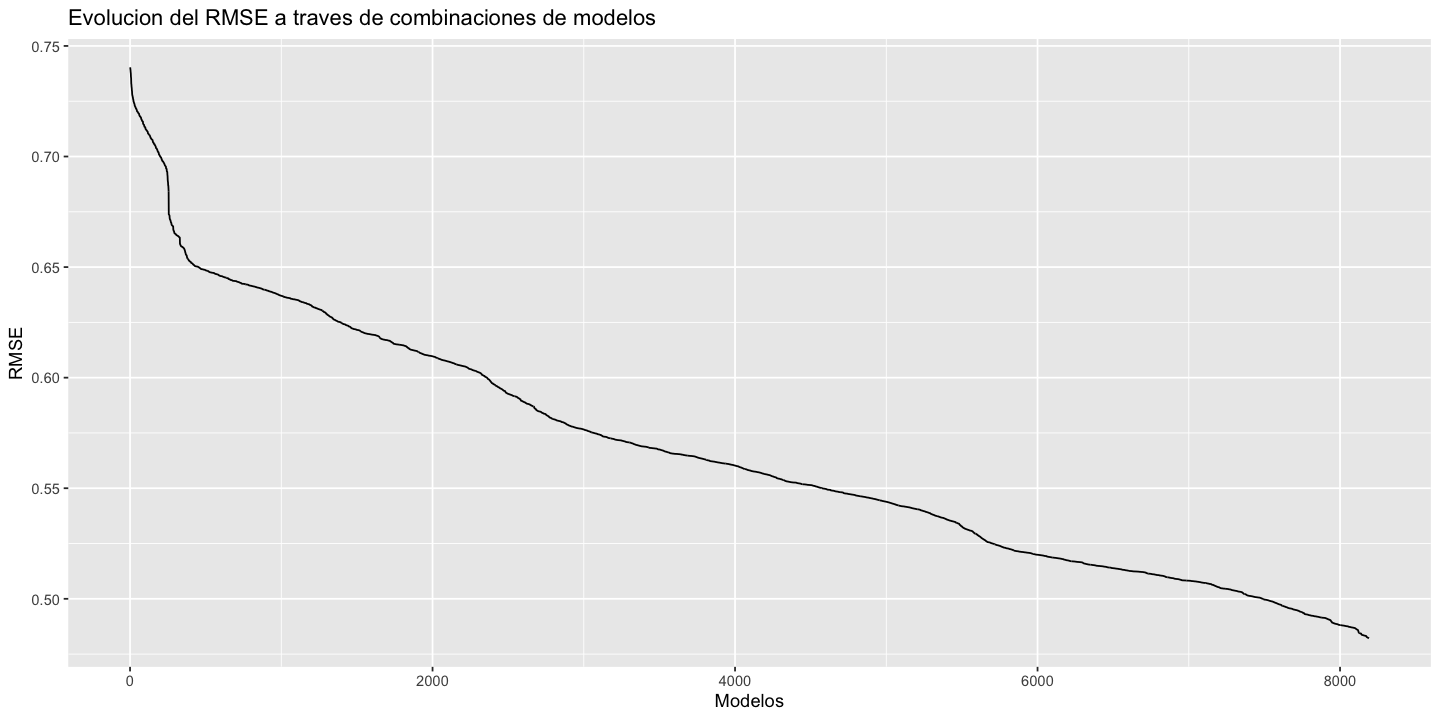

In [ ]:
resultados_modelos <- resultados_modelos[order(resultados_modelos$rmse), ]



ggplot(resultados_modelos, aes(x = orden, y = rmse)) +
  geom_line( size = .5) +  
  labs(title = "Evolucion del RMSE a traves de combinaciones de modelos",
       x = "Modelos",
       y = "RMSE") 

In [ ]:
resultados_modelos <- resultados_modelos[order(resultados_modelos$rmse), ][1:5,]

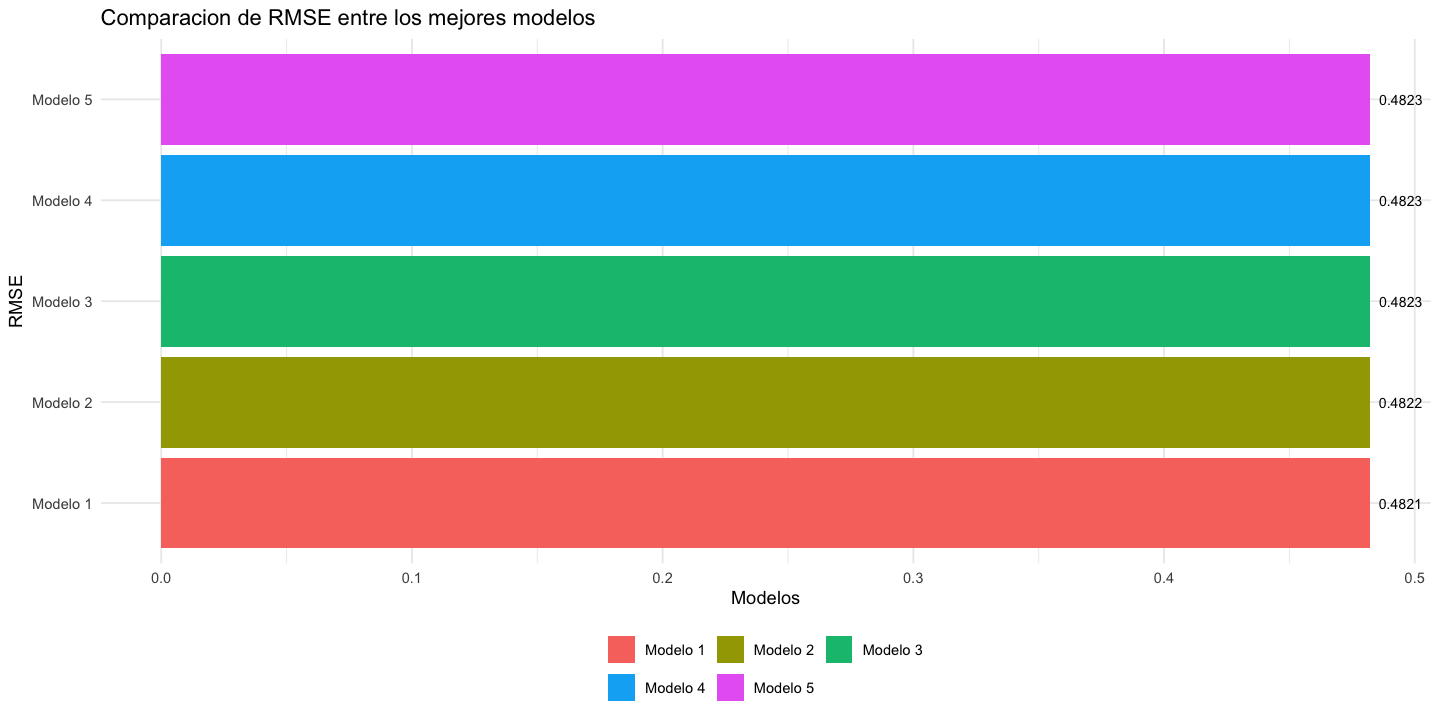

In [ ]:

ggplot(resultados_modelos, aes(x = reorder(top, rmse), y = rmse, fill=top)) +
  geom_bar(stat = "identity") +
  coord_flip() +  
  geom_text(aes(label = round(rmse, 4)),  
            hjust = -0.2,  
            size = 3) + 
  theme_minimal() +
  labs(title = "Comparacion de RMSE entre los mejores modelos", 
       x = "RMSE", 
       y = "Modelos") +
  theme(legend.position = "bottom",  
        legend.title = element_blank()) +  
  guides(fill = guide_legend(nrow = 2, byrow = TRUE))  

In [ ]:
lista_modelos <- resultados_modelos$modelo

rmse_1 <- rmse_2 <- rmse_3 <- rmse_4 <- rmse_5 <- NA

# Re-estimar los modelos y calcular el RMSE
model_1 <- lm(as.formula(lista_modelos[1]), data = training_set)
pred_1 <- predict(model_1, newdata = test_set)
rmse_1 <- sqrt(mean((test_set[['log_wage']] - pred_1)^2))

model_2 <- lm(as.formula(lista_modelos[2]), data = training_set)
pred_2 <- predict(model_2, newdata = test_set)
rmse_2 <- sqrt(mean((test_set[['log_wage']] - pred_2)^2))

model_3 <- lm(as.formula(lista_modelos[3]), data = training_set)
pred_3 <- predict(model_3, newdata = test_set)
rmse_3 <- sqrt(mean((test_set[['log_wage']] - pred_3)^2))

model_4 <- lm(as.formula(lista_modelos[4]), data = training_set)
pred_4 <- predict(model_4, newdata = test_set)
rmse_4 <- sqrt(mean((test_set[['log_wage']] - pred_4)^2))

model_5 <- lm(as.formula(lista_modelos[5]), data = training_set)
pred_5 <- predict(model_5, newdata = test_set)
rmse_5 <- sqrt(mean((test_set[['log_wage']] - pred_5)^2))


In [ ]:
print(resultados_modelos)

                                                                                                                                                                 modelo
60697                  log_wage ~ maxEducLevel + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + I(age^3) + sizeFirm + cotPension + bonif + estrato1
64029         log_wage ~ maxEducLevel + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + I(age^3) + formal + sizeFirm + cotPension + bonif + estrato1
53746                             log_wage ~ maxEducLevel + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + sizeFirm + cotPension + bonif + estrato1
63063 log_wage ~ maxEducLevel + hoursWorkUsual + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + I(age^3) + sizeFirm + cotPension + bonif + estrato1
60732                    log_wage ~ maxEducLevel + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + formal + sizeFirm + cotPension + bonif + e

In [ ]:
predicciones <- predict(model_1, newdata = test_set)
errores <- test_set$log_wage - predicciones
summary(errores)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-2.753003 -0.268670 -0.013822 -0.002407  0.256713  2.708530 

### LOOCV

In [ ]:
lista_modelos <- resultados_modelos$modelo[1:2] 

# Inicializar variables para guardar los modelos y sus RMSE
rmse_1 <- rmse_2 <- NA

# Re-estimar los dos mejores modelos y calcular el RMSE en el conjunto de prueba (Test Set)
model_1 <- lm(as.formula(lista_modelos[1]), data = training_set)
pred_1 <- predict(model_1, newdata = test_set)
rmse_1 <- sqrt(mean((test_set[['log_wage']] - pred_1)^2))

model_2 <- lm(as.formula(lista_modelos[2]), data = training_set)
pred_2 <- predict(model_2, newdata = test_set)
rmse_2 <- sqrt(mean((test_set[['log_wage']] - pred_2)^2))

# Resultados RMSE de los 2 mejores modelos en el conjunto de prueba
rmse_test_set <- data.frame(
  Model = c("Modelo 1", "Modelo 2"),
  RMSE = c(rmse_1, rmse_2)
)

# Imprimir resultados del test set
print(rmse_test_set)


# Control para LOOCV
ctrl <- trainControl(method = "LOOCV")

# LOOCV para el Modelo 1
model_1_loocv <- train(as.formula(lista_modelos[1]), data = geih, method = 'lm', trControl = ctrl)
rmse_1_loocv <- sqrt(mean((model_1_loocv$pred$pred - geih$log_wage)^2))

# LOOCV para el Modelo 2
model_2_loocv <- train(as.formula(lista_modelos[2]), data = geih, method = 'lm', trControl = ctrl)
rmse_2_loocv <- sqrt(mean((model_2_loocv$pred$pred - geih$log_wage)^2))

# Comparar los resultados de RMSE entre el conjunto de prueba y LOOCV para los dos mejores modelos
rmse_comparison <- data.frame(
  Model = c("Modelo 1: Test Set", "Modelo 1: LOOCV",
            "Modelo 2: Test Set", "Modelo 2: LOOCV"),
  RMSE = c(rmse_1, rmse_1_loocv,
           rmse_2, rmse_2_loocv)
)

# Imprimir los resultados comparativos
print(rmse_comparison)

     Model      RMSE
1 Modelo 1 0.4821370
2 Modelo 2 0.4821716


ERROR: Error in na.fail.default(structure(list(log_wage = c(9.03662015487265, : missing values in object


## 4.3. LOOCV

Re-fit the top models: 4 & 5

In [ ]:
set.seed(555)

#  70-30 split
inTrain  <- createDataPartition(y = geih$log_wage, p = 0.70, list = FALSE)
training <- geih %>% filter(row_number() %in% inTrain)
testing  <- geih %>% filter(!row_number() %in% inTrain)

# Model 4: Employment + Education:Occupation
form_4  <- log_wage ~ poly(age, 2) + sex + p6210 + oficio + poly(hoursWorkUsual, 2) + relab + age:sex + p6210:oficio
model_4 <- lm(form_4, data = training)
predictions_4 <- predict(model_4, newdata = testing)
score4a <- calculate_rmse(testing$log_wage, predictions_4)

# Model 5: Full Model with Interactions
form_5 <- log_wage ~ poly(age, 2) + sex + p6210 + oficio + poly(hoursWorkUsual, 2) + relab + age:sex + p6210:oficio + relab:hoursWorkUsual
model_5 <- lm(form_5, data = training)
predictions_5 <- predict(model_5, newdata = testing)
score5a <- calculate_rmse(testing$log_wage, predictions_5)


In [ ]:
# LOOCV setup (using Caret)
ctrl <- trainControl(method = "LOOCV")

# LOOCV for Model 4
model_4c <- train(form_4, data = geih, method = 'lm', trControl = ctrl)
score4c <- RMSE(model_4c$pred$pred, geih$log_wage)

# LOOCV for Model 5
model_5c <- train(form_5, data = geih, method = 'lm', trControl = ctrl)
score5c <- RMSE(model_5c$pred$pred, geih$log_wage)

# results
comparison_results <- data.frame(
  Model = c("Model 4: Test Set", "Model 4: LOOCV",
            "Model 5: Test Set", "Model 5: LOOCV"),
  RMSE = c(score4a, score4c, score5a, score5c)
)

print(comparison_results)

## Runtime: 4.5 minutes

              Model      RMSE
1 Model 4: Test Set 0.5469061
2    Model 4: LOOCV 0.5595627
3 Model 5: Test Set 0.5463841
4    Model 5: LOOCV 0.5593856


Tras dicho ejercicio evidenciamos dos cosas. Primero, el RMSE es ligeramente mayor cuando utilizamos LOOCV en comparación con el test set. Esto es normal, ya que LOOCV es más exhaustivo y puede detectar variaciones que el conjunto de prueba puede pasar por alto si debido a la aleatoriedad escoge un conjunto de datos con menor variabilidad. Segundo, ambos modelos muestran un performance similar, lo que sugiere que la adición de interacciones adicionales en el Modelo 5 no mejora significativamente la capacidad predictiva.

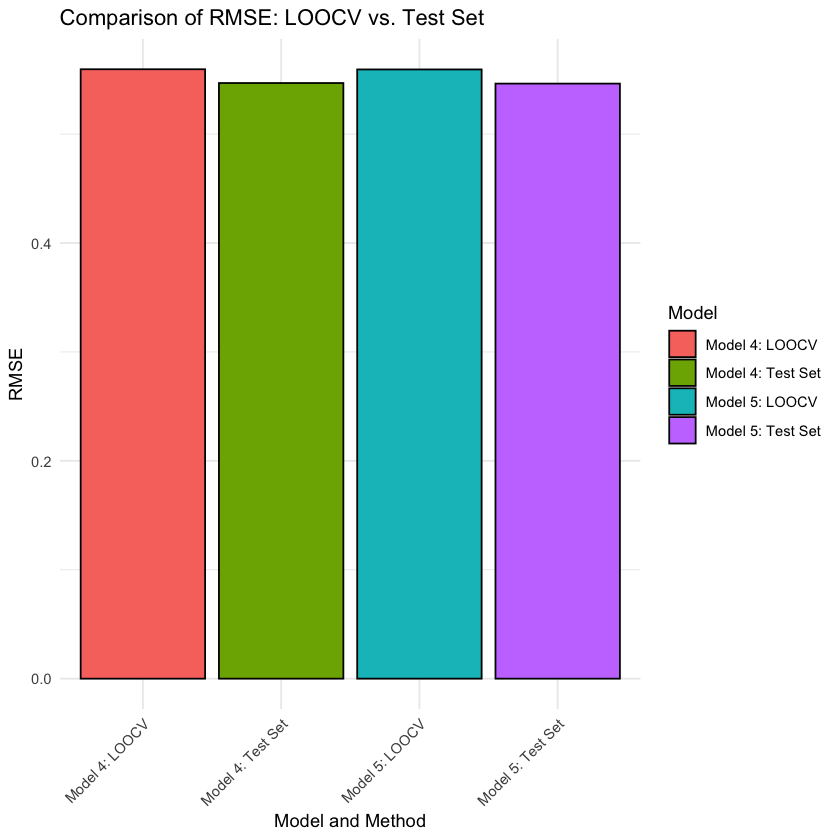

In [ ]:
ggplot(comparison_results, aes(x = Model, y = RMSE, fill = Model)) +
  geom_bar(stat = "identity", color = "black") +
  labs(title = "Comparison of RMSE: LOOCV vs. Test Set",
       x = "Model and Method", y = "RMSE") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

### LOOCV

In [ ]:
lista_modelos <- resultados_modelos$modelo[1:2]  # Solo tomamos los dos mejores

# Inicializar variables para guardar los modelos y sus RMSE
rmse_1 <- rmse_2 <- NA

# Re-estimar los dos mejores modelos y calcular el RMSE en el conjunto de prueba (Test Set)
model_1 <- lm(as.formula(lista_modelos[1]), data = training_set)
pred_1 <- predict(model_1, newdata = test_set)
rmse_1 <- sqrt(mean((test_set[['log_wage']] - pred_1)^2))

model_2 <- lm(as.formula(lista_modelos[2]), data = training_set)
pred_2 <- predict(model_2, newdata = test_set)
rmse_2 <- sqrt(mean((test_set[['log_wage']] - pred_2)^2))

# Resultados RMSE de los 2 mejores modelos en el conjunto de prueba
rmse_test_set <- data.frame(
  Model = c("Modelo 1", "Modelo 2"),
  RMSE = c(rmse_1, rmse_2)
)

# Imprimir resultados del test set
print(rmse_test_set)


# Control para LOOCV
ctrl <- trainControl(method = "LOOCV")
geih <- geih[!is.na(geih$bonif), ]

# LOOCV para el Modelo 1
model_1_loocv <- train(as.formula(lista_modelos[1]), data = geih, method = 'lm', trControl = ctrl)
rmse_1_loocv <- sqrt(mean((model_1_loocv$pred$pred - geih$log_wage)^2))

# LOOCV para el Modelo 2
model_2_loocv <- train(as.formula(lista_modelos[2]), data = geih, method = 'lm', trControl = ctrl)
rmse_2_loocv <- sqrt(mean((model_2_loocv$pred$pred - geih$log_wage)^2))

# Comparar los resultados de RMSE entre el conjunto de prueba y LOOCV para los dos mejores modelos
rmse_comparison <- data.frame(
  Model = c("Modelo 1: Test Set", "Modelo 1: LOOCV",
            "Modelo 2: Test Set", "Modelo 2: LOOCV"),
  RMSE = c(rmse_1, rmse_1_loocv,
           rmse_2, rmse_2_loocv)
)

# Imprimir los resultados comparativos
print(rmse_comparison)

     Model      RMSE
1 Modelo 1 0.4821370
2 Modelo 2 0.4821716
               Model      RMSE
1 Modelo 1: Test Set 0.4821370
2    Modelo 1: LOOCV 0.4746573
3 Modelo 2: Test Set 0.4821716
4    Modelo 2: LOOCV 0.4746896


### *BONO:* Utilizando *Leverage Values*

En lugar de recalcular el modelo N veces (siendo N el número de observaciones), utilizamos los *leverage values* para acelerar el cálculo de LOOCV.
El concepto clave en este ejercicio, es que en modelos lineales (e.g. regresión lineal), el error de predicción al dejar fuera la observación $i$ puede calcularse utilizando los residuos y los *leverage values*.



In [ ]:
model_1 <- lm(as.formula(lista_modelos[1]), data = geih)
X_1 <- model.matrix(model_1)
y_1 <- model.response(model.frame(model_1))
A_1 <- solve(t(X_1) %*% X_1)
vec_1 <- 1 / (1 - hatvalues(model_1))
N_1 <- nrow(X_1)
LOO_1 <- numeric(N_1)

for (i in 1:N_1) {
  new_beta_1 <- model_1$coefficients - vec_1[i] * model_1$residuals[i] * A_1 %*% as.vector(X_1[i, ])
  new_error_1 <- (y_1[i] - (X_1[i, ] %*% new_beta_1))^2
  LOO_1[i] <- new_error_1
}

looCV_error_1 <- mean(LOO_1)
rmse_1_loocv <- sqrt(looCV_error_1)

model_2 <- lm(as.formula(lista_modelos[2]), data = geih)
X_2 <- model.matrix(model_2)
y_2 <- model.response(model.frame(model_2))
A_2 <- solve(t(X_2) %*% X_2)
vec_2 <- 1 / (1 - hatvalues(model_2))
N_2 <- nrow(X_2)
LOO_2 <- numeric(N_2)

for (i in 1:N_2) {
  new_beta_2 <- model_2$coefficients - vec_2[i] * model_2$residuals[i] * A_2 %*% as.vector(X_2[i, ])
  new_error_2 <- (y_2[i] - (X_2[i, ] %*% new_beta_2))^2
  LOO_2[i] <- new_error_2
}

looCV_error_2 <- mean(LOO_2)
rmse_2_loocv <- sqrt(looCV_error_2)

rmse_comparison <- data.frame(
  Model = c("Modelo 1: Test Set", "Modelo 1: LOOCV",
            "Modelo 2: Test Set", "Modelo 2: LOOCV"),
  RMSE = c(rmse_1, rmse_1_loocv,
           rmse_2, rmse_2_loocv)
)

print(rmse_comparison)

               Model      RMSE
1 Modelo 1: Test Set 0.4821370
2    Modelo 1: LOOCV 0.4746573
3 Modelo 2: Test Set 0.4821716
4    Modelo 2: LOOCV 0.4746896


Como evidenciamos, el tiempo de ejecución es significativamente menor (0.2 segundos), ya que no es necesario estimar el modelo $n$ veces.
Asimismo, los RMSE obtenidos son equivalentes a los calculados con el método tradicional de LOOCV.

## Link entre LOOCV y *Leverage Values*

Anteriormente realizamos la validación cruzada de dejar-uno-fuera (LOOCV) para estimar el error de predicción de nuestros modelos utilizando las estadísticas de influencia, específicamente los valores de apalancamiento (\texttt{hatvalues}) y los residuos, para calcular eficientemente los errores de LOOCV sin volver a ajustar el modelo $N$ veces. Este enfoque es mucho más rápido y computacionalmente eficiente, especialmente para conjuntos de datos grandes.

El valor de apalancamiento de una observación, denotado como $h_i$, mide la influencia que un punto de datos tiene sobre su propio valor ajustado. Se deriva de los elementos diagonales de la matriz "hat" (también conocida como matriz de proyección $H$):

\begin{align*} H &= X(X'X)^{-1}X' \end{align*}

donde $X$ es la matriz de predictores.

Valores altos de apalancamiento (lo que implica que la observación tiene una gran influencia en el valor ajustado) pueden afectar significativamente los coeficientes de regresión.

En LOOCV, cada observación se deja fuera una vez, se vuelve a ajustar el modelo y se calcula el error de predicción para esa observación. Sin embargo, volver a ajustar el modelo cada vez es computacionalmente costoso. En lugar de volver a ajustar, utilizamos las estadísticas de influencia ajustando los coeficientes $\beta_{\text{nuevo}}$ sin necesidad de volver a ajustar completamente el modelo. Podemos hacer esto usando la fórmula:

\begin{align*} \beta_{\text{nuevo}} = \beta_{\text{(-i)}} &= \beta - \frac{r_i}{1 - h_i} \cdot A \cdot X_i \end{align*}

donde:

- $\beta$: Coeficientes de regresión originales.
- $r_i$: Residuo de la $i$-ésima observación.
- $h_i$: Apalancamiento de la $i$-ésima observación (elementos diagonales de $H$).
- $A$: Inversa de $X'X$, utilizada para actualizar los coeficientes.
- $X_i$: Vector de predictores de la $i$-ésima observación.


Usando los coeficientes actualizados ($\beta_{\text{nuevo}}$), el nuevo error de predicción ($\text{error}_{\text{nuevo}}$) para cada observación puede calcularse sin necesidad de volver a ajustar el modelo, haciendo que este enfoque sea eficiente. Así, en este sencillo ejercicio demostramos los *leverage values* permiten calcular eficientemente el error de predicción de LOOCV sin necesidad de volver a estimar el modelo, ya que cuantifican la influencia de cada observación en el ajuste del modelo y facilitan la actualización de los coeficientes al excluir individualmente cada observación.